# HW 8 : Forward Filtering

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

df = pd.read_csv("simdata.csv")
vy = df.values[0][1:]
mF = df.values[1:][:, 1:]
T, p = vy.shape[0], mF.shape[0]
vm0 = np.zeros((p, 1))
mC0 = 0.1*np.eye(p)
amG = [np.eye(p)]*T
amW = [0.1 * np.eye(p)]*T
vV = 0.5 * np.ones(T)

In [50]:
# prepare
    
def FF(vy, mF, vV, amG, amW, vm0, mC0):
    
    
    T, p = vy.shape[0], mF.shape[0]
    ma = np.zeros((T, p))
    mm = np.zeros((T, p))
    mb = np.zeros((T, p))
    amR = [np.eye(p)]*T
    amC = [np.eye(p)]*T
    
    
    vm = vm0
    mC = mC0
    
    # main loop
    for t in range(T):
        
        if t > 0:
            vm = mm[t-1,:].reshape([p, 1])
            mC = amC[t-1]
            
        
        currentF = mF[:, t].reshape([1, p])
        
        ma[t, :] = np.dot(vm.T, amG[t])
        amR[t] = np.dot(np.dot(amG[t], mC), amG[t].T) + amW[t]
        dq = np.dot(np.dot(currentF, amR[t]), currentF.T) + vV[t]
        mA = np.divide(np.dot(currentF, amR[t]), dq)
        
        mm[t, :] = np.dot(vm.T, amG[t]) + np.multiply(mA, vy[t] - np.dot(currentF, np.dot(vm.T, amG[t]).T))
        amC[t] = amR[t] - np.multiply(np.dot(mA.T, mA), dq)
        
    return mm, amC

In [51]:
mm, mC = FF(vy, mF, vV, amG, amW, vm0, mC0)
b1, b2, b3, b4 = mm[:, 0], mm[:, 1], mm[:, 2] ,mm[:, 3]

In [52]:
true = pd.read_csv("truebeta.csv")
beta1 = true.values[0, 1:]
beta2 = true.values[1, 1:]
beta3 = true.values[2, 1:]
beta4 = true.values[3, 1:]

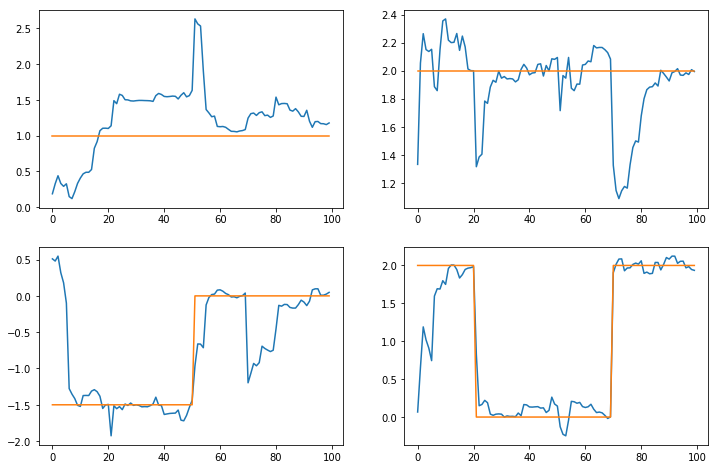

In [53]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

ax[0, 0].plot(b1)
ax[0,0].plot(beta1)
ax[0, 1].plot(b2)
ax[0, 1].plot(beta2)
ax[1, 0].plot(b3)
ax[1, 0].plot(beta3)
ax[1, 1].plot(b4)
ax[1, 1].plot(beta4)

# HW 9 (Q1 a): Forward Filtering and Backward Sampling 

In [61]:
def FFBS(nsim, vy, mF, vV, amG, amW, vm0, mC0):
    
    T, p = vy.shape[0], mF.shape[0]
    ma = np.zeros((T, p))
    mm = np.zeros((T, p))
    mb = np.zeros((T, p))
    amR = [np.eye(p)]*T
    amC = [np.eye(p)]*T
    amb = [0]*T
    
    vm = vm0
    mC = mC0
    
    # ff loop
    for t in range(T):
        
        if t > 0:
            vm = mm[t-1,:].reshape([p, 1])
            mC = amC[t-1]
            
        currentF = mF[:, t].reshape([1, p])
        
        ma[t, :] = np.dot(vm.T, amG[t])
        amR[t] = np.dot(np.dot(amG[t], mC), amG[t].T) + amW[t]
        dq = np.dot(np.dot(currentF, amR[t]), currentF.T) + vV[t]
        mA = np.divide(np.dot(currentF, amR[t]), dq)
        
        m = np.dot(vm.T, amG[t]) + np.multiply(mA, vy[t] - np.dot(currentF, np.dot(vm.T, amG[t]).T))
        print(m)
        mm[t, :] = m
        
        C = amR[t] - np.multiply(np.dot(mA.T, mA), dq)
        amC[t] = C
    
    # BS loop
    C_float = C.astype(np.float64)
    if m.ndim == 1:
        mb = np.random.normal(m.astype(np.float64), np.sqrt(C_float), size = nsim)
    else:
        mb = np.random.multivariate_normal(m[0].astype(np.float64), C_float, size = nsim)
        
    amb[T-1] = mb
    
    for t in reversed(range(T-1)):           
        if m.ndim == 1:
            mB = np.dot(np.dot(amC[t], amG[t+1].T), 1/amR[t+1].astype(np.float64))
            mH = amC[t] - [mB[0]**2*amR[t+1][0]]
            mean = mm[t, :] + (mb - ma[t+1, :])*mB
            H_float = mH.astype(np.float64)
            mb = mean.astype(np.float64) + np.random.normal(np.zeros(p), np.sqrt(H_float), size = nsim)
            
        else:
            mB = np.dot(np.dot(amC[t], amG[t+1].T), np.linalg.inv(amR[t+1].astype(np.float64)))
            mH = amC[t]- np.dot(np.dot(mB, amR[t+1]), mB.T)
            mean = mm[t, :] + np.dot((mb - ma[t+1, :]), mB.T)
            H_float = mH.astype(np.float64)
            mb = mean.astype(np.float64) + np.random.multivariate_normal(np.zeros(p), H_float, size = nsim)
            
        amb[t] = mb
        
    return amb

In [57]:
nsim  = 5000
amb = FFBS(nsim, vy, mF, vV, amG, amW, vm0, mC0)

[0.18714597 1.33188203 0.50984784 0.06629849]
[0.3269491  2.05364934 0.47981017 0.65250272]
[0.43880434 2.26359674 0.54770644 1.18940216]
[0.33122627 2.15030033 0.31947089 1.01890103]
[0.29090714 2.13667432 0.18000136 0.90893515]
[ 0.32643099  2.1522893  -0.09904245  0.7440912 ]
[ 0.14780376  1.8856749  -1.27710974  1.59599319]
[ 0.1196199   1.85755591 -1.35318028  1.69243965]
[ 0.21636524  2.1488573  -1.41446755  1.68883477]
[ 0.33198692  2.35449731 -1.50726623  1.79860851]
[ 0.40661667  2.36889579 -1.52221426  1.75012242]
[ 0.46543609  2.21743652 -1.37283096  1.95963224]
[ 0.48726494  2.20005433 -1.37105034  2.00554288]
[ 0.48732541  2.20207591 -1.37249531  2.00481449]
[ 0.52613992  2.26479311 -1.31141796  1.94597368]
[ 0.82269325  2.14462758 -1.29180661  1.83409299]
[ 0.91539128  2.24647028 -1.31971924  1.87883294]
[ 1.06762583  2.16943559 -1.38205197  1.94713026]
[ 1.10202655  2.01211374 -1.55035969  1.96444898]
[ 1.10299059  2.00029117 -1.5020746   1.97056739]
[ 1.0991889   1.9991

In [33]:
# aggregate

b1 = np.zeros(T)
b2 = np.zeros(T)
b3 = np.zeros(T)
b4 = np.zeros(T)
beta = [b1, b2, b3, b4]

for t in range(T-1):
    for i in range(p):
        beta[i][t] = np.mean(amb[t][:, i])

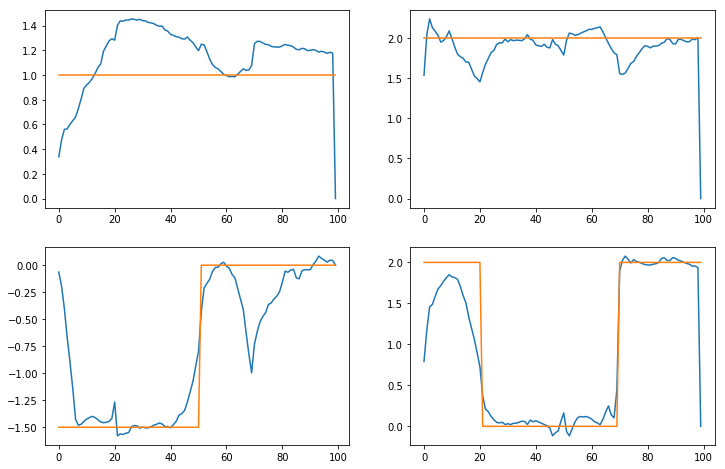

In [34]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

ax[0, 0].plot(b1)
ax[0, 0].plot(beta1)
ax[0, 1].plot(b2)
ax[0, 1].plot(beta2)
ax[1, 0].plot(b3)
ax[1, 0].plot(beta3)
ax[1, 1].plot(b4)
ax[1, 1].plot(beta4)

# HW 9 (Q2 b) : Stochastic Volatity Model

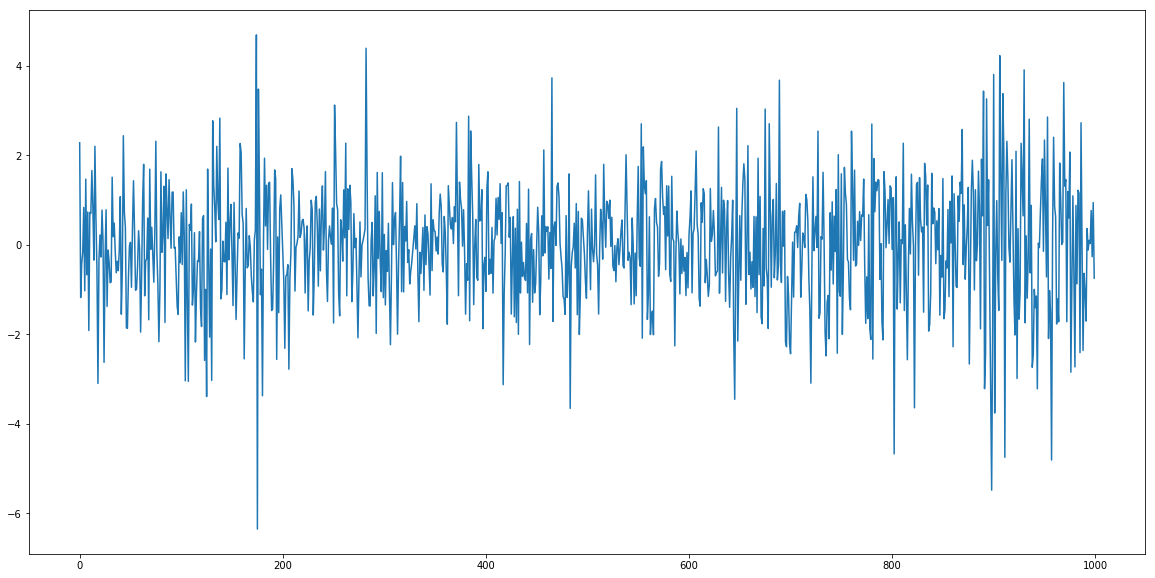

In [35]:
# data
svdata = pd.read_csv("sv_simdata.csv")
vy = svdata.values[0][1:]
plt.figure(figsize=(20, 10)) 
plt.plot(vy)
plt.show()

In [36]:
# true parameters
T = vy.shape[0]
vm0 = np.array([0])
mC0 = np.array([0.1])
dmu = np.array([0])
dphi = np.array([0.95])
dsig2 = np.array([0.1])
amG = [dphi]*T
amW = [dsig2]*T

In [37]:
# approximation
vy = np.array([np.log(i**2) + 1.27 - dmu for i in vy])
vV = 2.22**2 * np.ones(T)
mF = np.ones((1, T))

In [38]:
nsim = 5000
svamb = FFBS(nsim,vy,mF,vV,amG,amW,vm0,mC0);

[[0.10840578]]
[0.]
[0.17950022]
[0.]
[0.13071272]
[0.]
[-0.0416054]
[0.]
[0.03401809]
[0.]
[0.13969272]
[0.]
[0.2980893]
[0.]
[0.29993461]
[0.]
[0.31808654]
[0.]
[0.51453942]
[0.]
[0.50054817]
[0.]
[0.48310194]
[0.]
[0.63480442]
[0.]
[0.63294516]
[0.]
[0.45766827]
[0.]
[0.67007999]
[0.]
[0.60045984]
[0.]
[0.51593047]
[0.]
[0.78800112]
[0.]
[0.58615609]
[0.]
[0.32878273]
[0.]
[0.1522485]
[0.]
[0.20486244]
[0.]
[-0.24118137]
[0.]
[0.10769915]
[0.]
[-0.00630036]
[0.]
[0.07064543]
[0.]
[0.24789982]
[0.]
[-0.08286423]
[0.]
[-0.13235245]
[0.]
[-0.02099917]
[0.]
[0.07020623]
[0.]
[0.26578611]
[0.]
[0.01519901]
[0.]
[-0.00451247]
[0.]
[-0.26233049]
[0.]
[-0.1924242]
[0.]
[-0.23605335]
[0.]
[-0.18498448]
[0.]
[-0.43903781]
[0.]
[-0.23716265]
[0.]
[0.00776789]
[0.]
[0.01904172]
[0.]
[0.31605246]
[0.]
[0.33065925]
[0.]
[0.22659364]
[0.]
[0.44012659]
[0.]
[0.62447557]
[0.]
[0.6015]
[0.]
[-0.07820098]
[0.]
[-0.51642019]
[0.]
[-0.32777051]
[0.]
[-0.34144494]
[0.]
[-0.09737523]
[0.]
[-0.17382621]
[0

[0.]
[-0.34681482]
[0.]
[-0.73711721]
[0.]
[-0.51239769]
[0.]
[-0.33481193]
[0.]
[-0.26561281]
[0.]
[-0.10332031]
[0.]
[-0.61518726]
[0.]
[-0.49780082]
[0.]
[-0.44982341]
[0.]
[-0.36908053]
[0.]
[-0.97533419]
[0.]
[-0.74845759]
[0.]
[-1.05224402]
[0.]
[-1.16990351]
[0.]
[-1.03622117]
[0.]
[-1.22379079]
[0.]
[-1.16295358]
[0.]
[-0.98771609]
[0.]
[-0.87140174]
[0.]
[-0.75065628]
[0.]
[-0.58631289]
[0.]
[-0.24035974]
[0.]
[-0.12542057]
[0.]
[-0.19090046]
[0.]
[-0.39009893]
[0.]
[-0.44489183]
[0.]
[-0.19916295]
[0.]
[-0.14672411]
[0.]
[-0.70685054]
[0.]
[-0.42607805]
[0.]
[-0.57299472]
[0.]
[-0.34058161]
[0.]
[-0.26976573]
[0.]
[0.00371766]
[0.]
[-0.11940309]
[0.]
[-0.12153787]
[0.]
[0.21589332]
[0.]
[0.45419912]
[0.]
[0.66761156]
[0.]
[0.75180397]
[0.]
[0.79472281]
[0.]
[0.87618419]
[0.]
[0.97582741]
[0.]
[0.98108952]
[0.]
[0.8730398]
[0.]
[1.00918893]
[0.]
[1.07645859]
[0.]
[1.12406008]
[0.]
[1.22488356]
[0.]
[1.13440973]
[0.]
[1.10309834]
[0.]
[0.93530785]
[0.]
[0.7409617]
[0.]
[0.69039

[0.44128554]
[0.]
[0.60925221]
[0.]
[0.68082656]
[0.]
[0.60715905]
[0.]
[0.78797942]
[0.]
[1.00531011]
[0.]
[0.97336517]
[0.]
[0.97601906]
[0.]
[0.88531075]
[0.]
[1.08038217]
[0.]
[1.02446004]
[0.]
[0.97560534]
[0.]
[0.99914836]
[0.]
[1.009342]
[0.]
[1.16226645]
[0.]
[1.31738597]
[0.]
[0.55964272]
[0.]
[0.77304305]
[0.]
[0.69872482]
[0.]
[0.73474297]
[0.]
[0.85898361]
[0.]
[0.66105891]
[0.]
[0.26999603]
[0.]
[-0.09692723]
[0.]
[-0.66836033]
[0.]
[-0.50036052]
[0.]
[-0.56458821]
[0.]
[-0.37049104]
[0.]
[-0.25051412]
[0.]


In [39]:
beta = np.zeros(T-1)
for t in range(T-1):
    beta[t] = np.mean(svamb[t])

In [40]:
truevol = pd.read_csv("sv_truevol.csv")
truevol = truevol.values[0][1:]

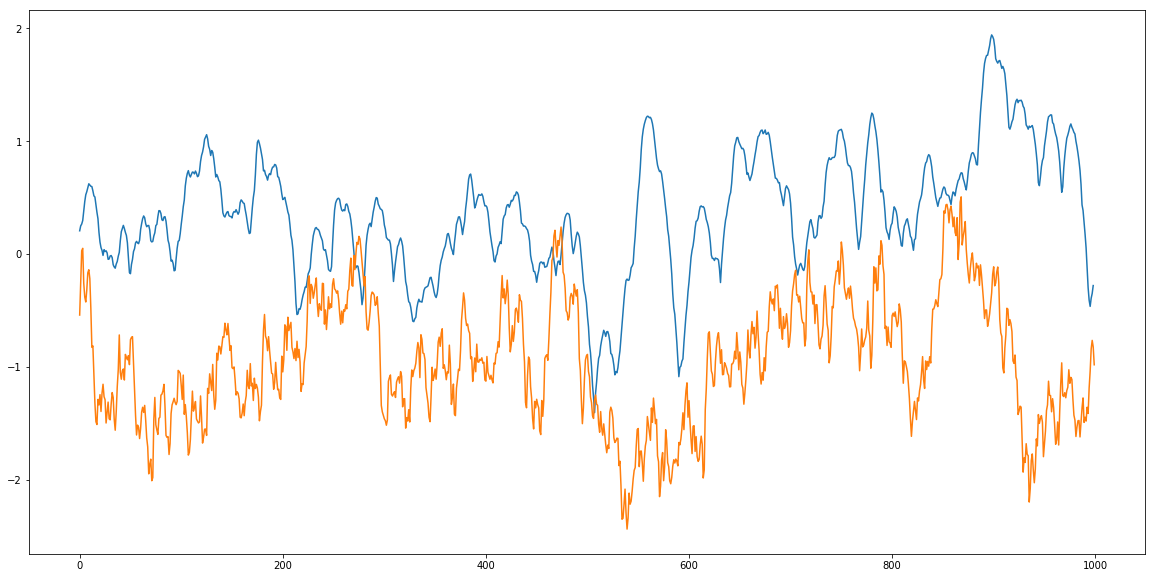

In [41]:
plt.figure(figsize=(20, 10)) 
plt.plot(range(0, T-1), beta)
plt.plot(range(0, T), truevol)
plt.show()

# HW 10 

In [62]:
np.random.seed(123)
# prepare
vy = pd.read_csv("sv_simdata.csv").values[0][1:]
nT = vy.shape[0]
vy = np.array([np.log(i**2) for i in vy])
nsim = 100
nburn = 1000
dC0 = 2

# priors
## mu
dmm = 0
dCm = 1
## phi
dmp = 0.9
dCp = 0.1
## sigma
da0 = 0.1
db0 = 0.1

# mixture setup
nK = 10
vp_mix = [0.00609, 0.04775, 0.13057,0.20674,0.22715,0.18842,0.12047,0.05591,0.01575,0.00115]
vm_mix = [1.92677,1.34744,0.73504,0.02266,-0.85173,-1.97278,-3.46788,-5.55246,-8.68384,-14.65000]
vv2_mix = [0.11265,0.17788,0.26768,0.40611,0.62699,0.98583,1.57469,2.54498,4.16591,7.33342]

# initial values
dmu = dmm + np.sqrt(dCm) * np.random.normal()
while True:
    dphi = np.random.normal(loc = dmp, scale = np.sqrt(dCp))
    if abs(dphi) < 1:
        break
dsig2 = 1/np.random.gamma(da0, db0)
vs = np.random.choice(len(vp_mix), nT, p=vp_mix)

amG = [np.array([dphi])]*nT
amW = [np.array([dsig2])]*nT
mF = np.ones((1, nT))
mh = np.zeros((nsim, nT + 1))
vphi = np.zeros(nsim)
vmu = np.zeros(nsim)
vsig2 = np.zeros(nsim)

In [63]:
# MCMC
for i in range(nsim):
    
    # FFBS part
    vy_star = vy - dmu - np.array([vm_mix[j] for j in vs])
    vV = np.array([vv2_mix[j] for j in vs])
    amG = [np.array([dphi])]*nT
    amW = [np.array([dsig2])]*nT
    vh_star = FFBS(1,vy_star,mF,vV,amG,amW,np.array([0]),dC0*dsig2)
    
    # posterior for h_0^star
    vhstar0 = np.random.normal(vh_star[0]*dphi*dC0/(dphi**2 * dC0 + 1), np.sqrt(dsig2 * dC0/(dphi**2 * dC0 + 1)))
    vh_star = [np.array([[vhstar0]])]+vh_star

    # sampling phi
    S1 = np.sum([vh_star[i]**2 for i in range(0, nT)])
    S2 = np.sum([vh_star[i]*vh_star[i-1] for i in range(1, nT+1)])
    alpha = S2/S1
    beta2 = dsig2/S1
    dmphi = (alpha * dCp + dmp * beta2)/(beta2 + dCp)
    dCphi = beta2*dCp/(beta2 + dCp)
    dphi = np.random.normal(loc = dmphi, scale = np.sqrt(dCphi))
    
    # sampling mu
    vh = [i + dmu for i in vh_star]
    S4 = np.sum([vh[i] - dphi*vh[i-1] for i in range(1, nT+1)])
    delta = (vh[0] + dC0*(1-dphi)*S4)/(1 + dC0*nT*(1-dphi)**2)
    eta2 = dsig2*dC0/(1 + dC0*nT*(1-dphi)**2)
    dmmu = (delta * dCm + dmm * eta2)/(dCm + eta2)
    dCmu = dCm * eta2 / (dCm + eta2)
    dmu = np.random.normal(loc = dmmu, scale = np.sqrt(dCmu))
    
    # sampling sigma
    S3 = np.sum([(vh_star[i] - dphi*vh_star[i-1])**2 for i in range(1, nT+1)])
    da = (nT + 1)/2 + da0
    db = 1/(db0 + S3/2)
    dsig2 = 1/np.random.gamma(shape = da, scale = db)
    
    # sampling latent
    for t in range(1, nT):
        vp = [vp_mix[k] * np.exp(-(vy_star[t] - vm_mix[k] - vh_star[t])**2/(2 * vv2_mix[k])) for k in range(nK)]
        newvp = [p[0]/sum(vp)[0] for p in vp]
        vs[t] = np.random.choice(len(newvp), 1, p=newvp)
        
    # store
    if i >= 0:
        vh = [i + dmu for i in vh_star]
        mh[i][:] = vh
        vphi[i] = dphi
        vmu[i] = dmu
        vsig2[i] = dsig2

[[8.25832874]]
[3.40649948]
[0.20578525]
[-1.5378323]
[0.69490758]
[3.10518955]
[2.70314439]
[-0.4467673]
[1.30826184]
[4.34586555]
[-0.30237244]
[-0.36468065]
[2.94197756]
[1.58178829]
[0.91571066]
[6.10013175]
[2.06991809]
[0.68409479]
[5.30161151]
[-1.10547123]
[-1.97331751]
[-1.52634836]
[0.5478923]
[-2.44354856]
[2.27590364]
[-0.32995625]
[1.43726815]
[2.57183474]
[-2.3259933]
[-0.83377223]
[1.60185533]
[4.16597011]
[7.42971953]
[-1.47459705]
[1.59881519]
[-3.54453198]
[0.11619794]
[-0.05692781]
[3.43843363]
[-3.05248265]
[2.06935535]
[10.51514184]
[0.81543164]
[3.71080225]
[-0.30576221]
[2.68940307]
[3.16967189]
[3.18526017]
[0.47418894]
[-6.23615904]
[-3.91133897]
[2.92991512]
[2.66755523]
[2.6529058]
[0.87478411]
[1.96581382]
[3.0336603]
[1.58374328]
[2.22849628]
[-4.22551401]
[4.36265034]
[0.29732605]
[1.02188006]
[3.10320956]
[0.61538523]
[2.4825755]
[0.77058769]
[2.01897142]
[0.7704466]
[2.98013755]
[-2.61407249]
[-1.52836487]
[-2.71627399]
[2.67987724]
[-1.45647738]
[4.7121

[3.37162547]
[9.97751565]
[1.55839596]
[5.71489325]
[9.25122472]
[0.21846058]
[4.49961444]
[0.33648016]
[3.80950079]
[5.93190195]
[2.82937669]
[2.44730739]
[5.47985107]
[6.00462439]
[6.17191768]
[2.20822423]
[3.60860695]
[2.72436098]
[-6.12444546]
[0.03134522]
[1.52597494]
[1.63363307]
[-2.16694427]
[2.36394216]
[1.14001137]
[11.08796856]
[3.26206992]
[-0.97315788]
[0.75206815]
[2.05902324]
[1.37504656]
[0.46409648]
[0.18816992]
[7.23651585]
[3.05660819]
[-3.48654354]
[0.7020784]
[0.50754657]
[5.10389017]
[2.14081721]
[0.80974737]
[3.07282402]
[4.83822541]
[1.9334338]
[3.73166395]
[2.20777327]
[3.39692483]
[-6.32159648]
[-5.2251513]
[3.88037264]
[2.66155104]
[10.94206398]
[-2.75029141]
[2.75361944]
[0.5134175]
[0.40313565]
[5.13706262]
[1.2183118]
[3.09537672]
[2.78118137]
[5.07241898]
[-0.7925008]
[3.67873663]
[1.62531075]
[0.13895171]
[3.07056667]
[2.31604605]
[3.01964403]
[4.25717954]
[1.07905099]
[-7.84914143]
[-3.71363175]
[2.30911352]
[2.47552421]
[1.81782116]
[3.01751992]
[4.889

ValueError: could not broadcast input array from shape (1000) into shape (1)

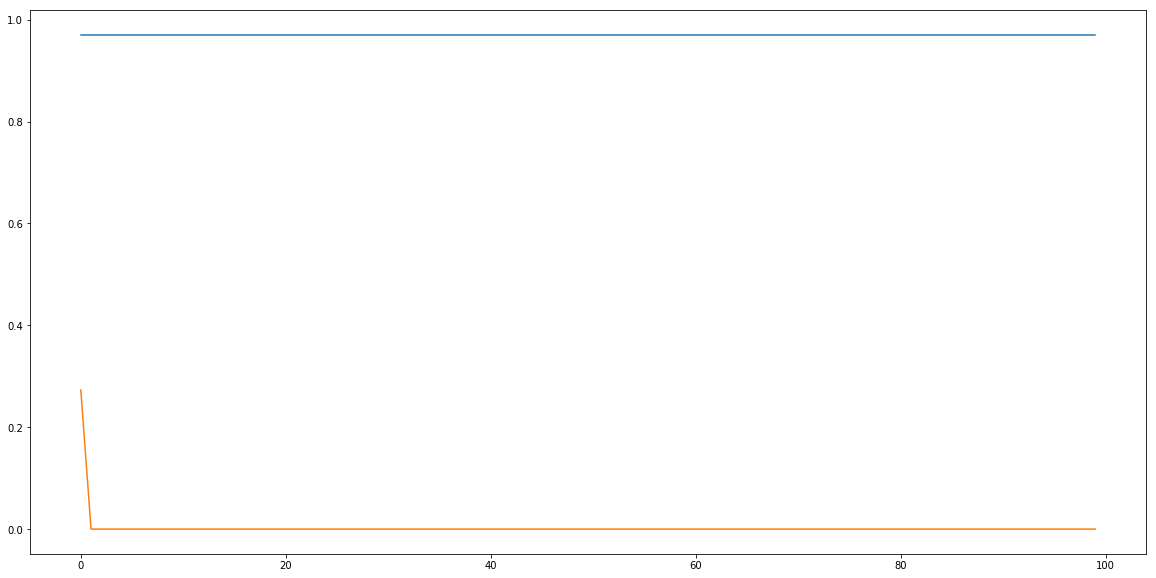

In [60]:
truephi = np.ones(nsim)*0.97
plt.figure(figsize=(20, 10))
plt.plot(truephi)
plt.plot(vphi)

In [ ]:
truemu = np.ones(nsim)*2*np.log(0.65)
plt.figure(figsize=(20, 10)) 
plt.plot(truemu)
plt.plot(vmu)
plt.show()

In [ ]:
truesig = np.ones(nsim)*0.15**2
plt.figure(figsize=(20, 10)) 
plt.plot(truesig)
plt.plot(vsig2)
plt.show()

In [ ]:
df = pd.read_csv("sv_truevol.csv")
truevol = df.values[0][1:]

result = np.zeros(nT)
for t in range(nT):
    result[t] = np.mean(mh[100:, t])

plt.figure(figsize=(20, 10)) 
plt.plot(result)
plt.plot(truevol)
plt.ylim(-2.5, 2.5)
plt.show()